# Intent classification

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
from transformers import pipeline
bert_cpkt = 'transformersbook/bert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', model=bert_cpkt, device=0)

config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from time import time
query = "I'd like to rent a vehicle from nov 1st to nov 15th in paris and I need a 15 passenger van"

start = time()
pipe(query)
end = time()
print(f'{(end - start) * 1000:.2f}', 'ms')

874.11 ms


# Benchmark

Constraint trade-off:
- model performance on test data
- latency
- memory

In [5]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipe = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        pass

    def compute_size(self):
        pass

    def time_pipeline(self):
        # measures latenc
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())

        return metrics

In [8]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00


In [9]:
from datasets import load_dataset
clinc = load_dataset('clinc_oos', 'plus') # plus contains out-of-scope training samples

README.md:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [10]:
sample = clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [11]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [14]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [15]:
import evaluate
accuracy_score = evaluate.load('accuracy')
accuracy_score.compute(references=[0], predictions=[0])

{'accuracy': 1.0}

In [16]:
example = clinc['test'][0]
print(example)

print(example['text'])
print(pipe(example['text'])[0])

{'text': 'how would you say fly in italian', 'intent': 61}
how would you say fly in italian
{'label': 'translate', 'score': 0.5855258703231812}


In [17]:
def compute_accuracy(self):
    preds, labels = [], [] # initialize predictions and labels
    for example in self.dataset:
        pred_str = self.pipe(example['text'])[0]['label']
        preds.append(intents.str2int(pred_str))

        intent_int = example['intent']
        labels.append(intent_int)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy: {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [18]:
torch.save(pipe.model.state_dict(), 'model.pt')

In [19]:
from pathlib import Path

Path('model.pt').stat().st_size /( 1024 * 1024 )

418.1497859954834

In [20]:
from pathlib import Path

def compute_size(self):
    state_dict = self.pipe.model.state_dict()
    tmp_path = 'model.pt'
    torch.save(state_dict, tmp_path)

    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    Path(tmp_path).unlink()

    print(f'Model size (MB): {size_mb:.2f}')
    return { 'size_mb': size_mb }

PerformanceBenchmark.compute_size = compute_size

In [21]:
import numpy as np
from time import perf_counter

def time_pipeline(self, query="What is the pin number of my account?"):
    latencies = []
    # warm up (10 times)
    for _ in range(10):
        self.pipe(query)

    # benchmark (100 times)
    for _ in range(100):
        start_time = perf_counter()
        self.pipe(query)
        end_time = perf_counter()
        latency = end_time - start_time
        latencies.append(latency)

    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)

    print(f'Average latency (ms): {time_avg_ms:.2f} +/- {time_std_ms:.2f}')

    return {
        'time_avg_ms': time_avg_ms,
        'time_std_ms': time_std_ms
    }

PerformanceBenchmark.time_pipeline = time_pipeline

In [22]:
pb = PerformanceBenchmark(pipe, clinc['test'])
perf_metrics = pb.run_benchmark()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Model size (MB): 418.15
Average latency (ms): 8.21 +/- 0.42
Accuracy: 0.867


In [27]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # get student cross-entropy loss and logits
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits

        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits

        loss_fct = nn.KLDivLoss(reduction='batchmean')
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [29]:
from transformers import AutoTokenizer

student_ckpt = 'distilbert-base-uncased'
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(samples):
    return student_tokenizer(samples['text'], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column('intent', 'labels')

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [31]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [33]:
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [35]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = AutoConfig.from_pretrained(
    student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

In [36]:
import torch
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [37]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
    .from_pretrained(teacher_ckpt, num_labels=num_labels)
    .to(device))
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distilbert_trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.320125,0.730323
2,3.816500,1.914817,0.844839
3,3.816500,1.189184,0.892581
4,1.733500,0.887629,0.912903
5,0.933500,0.801016,0.917097


TrainOutput(global_step=1590, training_loss=2.08356661526662, metrics={'train_runtime': 86.6742, 'train_samples_per_second': 879.731, 'train_steps_per_second': 18.345, 'total_flos': 414689637990180.0, 'train_loss': 2.08356661526662, 'epoch': 5.0})

In [38]:
distilbert_trainer.push_to_hub('training completed')

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1728635342.4ec1a53da9e6.661.0:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hieundx/distilbert-base-uncased-finetuned-clinc/commit/28aef68c28557badd62929a9de08501240e11d46', commit_message='training completed', commit_description='', oid='28aef68c28557badd62929a9de08501240e11d46', pr_url=None, pr_revision=None, pr_num=None)

In [39]:
finetuned_ckpt = 'hieundx/distilbert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', model=finetuned_ckpt)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [40]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())


In [42]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': 8.208068409994098,
  'time_std_ms': 0.4178787834561998,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88184547424316,
  'time_avg_ms': 22.10706348999679,
  'time_std_ms': 0.3061225305351042,
  'accuracy': 0.8563636363636363}}

## Find good hyper params with Optuna

In [43]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
    "alpha": trial.suggest_float("alpha", 0, 1),
    "temperature": trial.suggest_int("temperature", 2, 20)}

In [45]:
!pip install optuna ray[tune] sigopt wandb

In [46]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction='maximize', hp_space=hp_space
)

[I 2024-10-11 08:40:00,346] A new study created in memory with name: no-name-042c935a-8de8-4b1f-a5ce-c2cea97879f7
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.207789,0.585484
2,0.330200,0.102019,0.823871
3,0.330200,0.069508,0.876774
4,0.118600,0.054943,0.894839
5,0.077800,0.046117,0.900968
6,0.077800,0.042120,0.907097
7,0.063800,0.040696,0.907419


[I 2024-10-11 08:42:22,565] Trial 0 finished with value: 0.9074193548387097 and parameters: {'num_train_epochs': 7, 'alpha': 0.7135847914278676, 'temperature': 9}. Best is trial 0 with value: 0.9074193548387097.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.234478,0.605806
2,0.371400,0.109813,0.835161
3,0.371400,0.071865,0.880323
4,0.128200,0.055432,0.897419
5,0.081100,0.045907,0.906774
6,0.081100,0.041715,0.912581
7,0.065600,0.040194,0.914194


[I 2024-10-11 08:44:27,617] Trial 1 finished with value: 0.9141935483870968 and parameters: {'num_train_epochs': 7, 'alpha': 0.1768882888101525, 'temperature': 5}. Best is trial 1 with value: 0.9141935483870968.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194128,0.580323
2,0.311000,0.095868,0.820968
3,0.311000,0.065505,0.876774
4,0.111400,0.051601,0.895806
5,0.072600,0.042755,0.902903
6,0.072600,0.038221,0.910645
7,0.058300,0.035884,0.916129
8,0.052500,0.034880,0.915806


[I 2024-10-11 08:47:25,128] Trial 2 finished with value: 0.9158064516129032 and parameters: {'num_train_epochs': 8, 'alpha': 0.11696493254495632, 'temperature': 16}. Best is trial 2 with value: 0.9158064516129032.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.253248,0.620000
2,0.400600,0.114393,0.837419
3,0.400600,0.072781,0.886129
4,0.133800,0.055274,0.900645
5,0.082500,0.045528,0.909677
6,0.082500,0.041311,0.914194
7,0.066200,0.039772,0.916452


[I 2024-10-11 08:50:33,932] Trial 3 finished with value: 0.9164516129032259 and parameters: {'num_train_epochs': 7, 'alpha': 0.6771233130752202, 'temperature': 4}. Best is trial 3 with value: 0.9164516129032259.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.207390,0.581290
2,0.327600,0.104244,0.816452
3,0.327600,0.072876,0.872258
4,0.120900,0.058809,0.890645
5,0.082200,0.051325,0.893226
6,0.082200,0.049069,0.895161


[I 2024-10-11 08:52:17,372] Trial 4 finished with value: 0.8951612903225806 and parameters: {'num_train_epochs': 6, 'alpha': 0.025648058305642873, 'temperature': 10}. Best is trial 3 with value: 0.9164516129032259.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.223486,0.601935
2,0.354500,0.106723,0.831935
3,0.354500,0.071013,0.877742
4,0.124400,0.055351,0.895161


[I 2024-10-11 08:53:24,500] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204807,0.585161


[I 2024-10-11 08:53:40,764] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203079,0.578387


[I 2024-10-11 08:53:57,869] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192615,0.580000


[I 2024-10-11 08:54:15,662] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201687,0.565806


[I 2024-10-11 08:54:32,530] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.405208,0.665484
2,0.639000,0.136649,0.842903
3,0.639000,0.070452,0.901935
4,0.160700,0.050115,0.919032
5,0.079500,0.041719,0.927097
6,0.079500,0.036765,0.931613
7,0.059500,0.034034,0.935161
8,0.051500,0.032671,0.935161
9,0.051500,0.031309,0.934194
10,0.047900,0.030989,0.934839


[I 2024-10-11 08:58:44,686] Trial 10 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.6527567130893474, 'temperature': 2}. Best is trial 10 with value: 0.9348387096774193.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.405208,0.665484
2,0.639000,0.136649,0.842903
3,0.639000,0.070452,0.901935
4,0.160700,0.050115,0.919032
5,0.079500,0.041719,0.927097
6,0.079500,0.036765,0.931613
7,0.059500,0.034034,0.935161
8,0.051500,0.032671,0.935161
9,0.051500,0.031309,0.934194
10,0.047900,0.030989,0.934839


[I 2024-10-11 09:03:07,295] Trial 11 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.6518010090433821, 'temperature': 2}. Best is trial 10 with value: 0.9348387096774193.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.405208,0.665484
2,0.639000,0.136649,0.842903
3,0.639000,0.070452,0.901935
4,0.160700,0.050115,0.919032
5,0.079500,0.041719,0.927097
6,0.079500,0.036765,0.931613
7,0.059500,0.034034,0.935161
8,0.051500,0.032671,0.935161
9,0.051500,0.031309,0.934194
10,0.047900,0.030989,0.934839


[I 2024-10-11 09:07:42,924] Trial 12 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.6341848490572362, 'temperature': 2}. Best is trial 10 with value: 0.9348387096774193.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.405208,0.665484
2,0.639000,0.136649,0.842903
3,0.639000,0.070452,0.901935
4,0.160700,0.050115,0.919032
5,0.079500,0.041719,0.927097
6,0.079500,0.036765,0.931613
7,0.059500,0.034034,0.935161
8,0.051500,0.032671,0.935161
9,0.051500,0.031309,0.934194
10,0.047900,0.030989,0.934839


[I 2024-10-11 09:12:35,048] Trial 13 finished with value: 0.9348387096774193 and parameters: {'num_train_epochs': 10, 'alpha': 0.9413299055826995, 'temperature': 2}. Best is trial 10 with value: 0.9348387096774193.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.212707,0.600323


[I 2024-10-11 09:12:51,312] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407886,0.666129
2,0.641000,0.140042,0.840323
3,0.641000,0.072569,0.898710
4,0.164100,0.051786,0.917419
5,0.082000,0.043017,0.925161
6,0.082000,0.038173,0.930323
7,0.061800,0.035503,0.934516
8,0.054000,0.034324,0.935161
9,0.054000,0.033683,0.935806


[I 2024-10-11 09:16:03,299] Trial 15 finished with value: 0.9358064516129032 and parameters: {'num_train_epochs': 9, 'alpha': 0.8022880523515454, 'temperature': 2}. Best is trial 15 with value: 0.9358064516129032.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.212707,0.600323


[I 2024-10-11 09:16:19,537] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195967,0.587097


[I 2024-10-11 09:16:35,768] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.248999,0.626452


[I 2024-10-11 09:16:51,966] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206767,0.597097


[I 2024-10-11 09:17:08,254] Trial 19 pruned. 


In [49]:
best_run

BestRun(run_id='15', objective=0.9358064516129032, hyperparameters={'num_train_epochs': 9, 'alpha': 0.8022880523515454, 'temperature': 2}, run_summary=None)

In [50]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distil_trainer.train();

distil_trainer.push_to_hub('training complete')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.704076,0.740323
2,3.157000,1.395922,0.861290
3,3.157000,0.757362,0.913548
4,1.221300,0.513648,0.926774
5,0.497900,0.421867,0.939355
6,0.497900,0.391575,0.940968
7,0.303100,0.370807,0.945161
8,0.244400,0.366629,0.945161
9,0.244400,0.365032,0.944839


CommitInfo(commit_url='https://huggingface.co/hieundx/distilbert-base-uncased-distilled-clinc/commit/18300478f8fc0606d7d59427e65a1eccba05da2b', commit_message='training complete', commit_description='', oid='18300478f8fc0606d7d59427e65a1eccba05da2b', pr_url=None, pr_revision=None, pr_num=None)

## benchmark optimized model

In [52]:
distilled_ckpt = 'hieundx/distilbert-base-uncased-distilled-clinc'
pipe = pipeline('text-classification', model=distilled_ckpt)
optim_type = 'Distillation'
pb = PerformanceBenchmark(pipe, clinc['test'], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [53]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': 8.208068409994098,
  'time_std_ms': 0.4178787834561998,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88184547424316,
  'time_avg_ms': 22.10706348999679,
  'time_std_ms': 0.3061225305351042,
  'accuracy': 0.8563636363636363},
 'Distillation': {'size_mb': 255.88184547424316,
  'time_avg_ms': 22.491647899983036,
  'time_std_ms': 0.35315615698962044,
  'accuracy': 0.8849090909090909}}

In [70]:
import matplotlib.pyplot as plt

def plot_metrics(data):
    # Extracting the data for plotting
    models = list(data.keys())
    latency = [data[model]['time_avg_ms'] for model in models]
    accuracy = [data[model]['accuracy'] for model in models]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(latency, accuracy, color='b')

    # Annotate each point with its corresponding model name
    for i, model in enumerate(models):
        plt.annotate(model, (latency[i], accuracy[i]), textcoords="offset points", xytext=(0,5), ha='center')


    # Adding labels and title
    plt.xlabel('Latency (ms)')
    plt.ylabel('Accuracy')
    plt.title('Model Latency vs Accuracy')

    # Show the plot
    plt.grid(True)
    plt.show()



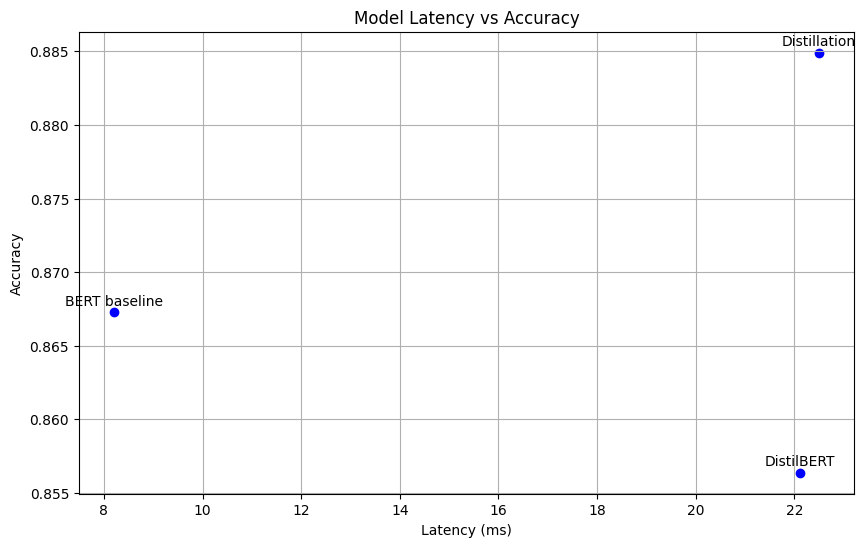

In [71]:
plot_metrics(perf_metrics)